# Sample efficiency (Section 3.2)

Plot how models improve under fine-tuning as a function of the amount of training data.

In [1]:
import os
import json
import numpy as np
from tqdm import tqdm
import seaborn as sns
import matplotlib
palette = sns.color_palette("colorblind")

from utils import responses_to_acc, majority_acc, load_responses

In [2]:
base_dir = 'results/sample-efficiency/'

accs = {}
for file in tqdm(os.listdir(base_dir)):
    task = file.split('-')[0]
    n = file.split('-')[1]
    seed = file.split('-')[2].split('.')[0]

    with open(os.path.join(base_dir, file), 'r') as f:
        responses = json.load(f)
    acc = responses_to_acc(responses)

    if task not in accs:
        accs[task] = {}
    
    if n not in accs[task]:
        accs[task][n] = {}

    accs[task][n][seed] = acc

# get the average accuracy for each task
for task, task_accs in accs.items():
    for n, n_accs in task_accs.items():
        accs[task][n] = {'mean': np.mean(list(n_accs.values())),
                         'stddev': np.std(list(n_accs.values())),
                         'n': len(n_accs)}

100%|██████████| 300/300 [00:00<00:00, 721.69it/s]


In [3]:
base_dir = 'results/model_responses'
models = {
    'llama-3-8b-instruct': 'Llama 3 8B Instruct',
    'gpt4': 'GPT-4',
    'lawma-8b': 'Lawma 8B',
}
model2color = {
    'llama-3-8b-instruct': palette[1],
    'gpt4': palette[2],
    'lawma-8b': palette[3],
}

responses = load_responses({}, models.keys(), base_dir)

accs2 = {}
for model, model_responses in responses.items():
    accs2[model] = {}
    for file, response in tqdm(model_responses.items()):
        accs2[model][file] = responses_to_acc(response, gpt4=model=='gpt4')
        
# compute accuracy of the majority classifier
accs2['maj'] = {k: majority_acc(v) for k, v in list(responses.values())[0].items()}

100%|██████████| 260/260 [00:01<00:00, 208.78it/s]


llama-3-8b-instruct has 260 tasks


100%|██████████| 260/260 [00:00<00:00, 3809.98it/s]


gpt4 has 260 tasks


100%|██████████| 260/260 [00:01<00:00, 216.51it/s]


lawma-8b has 260 tasks


100%|██████████| 260/260 [00:00<00:00, 1167.10it/s]


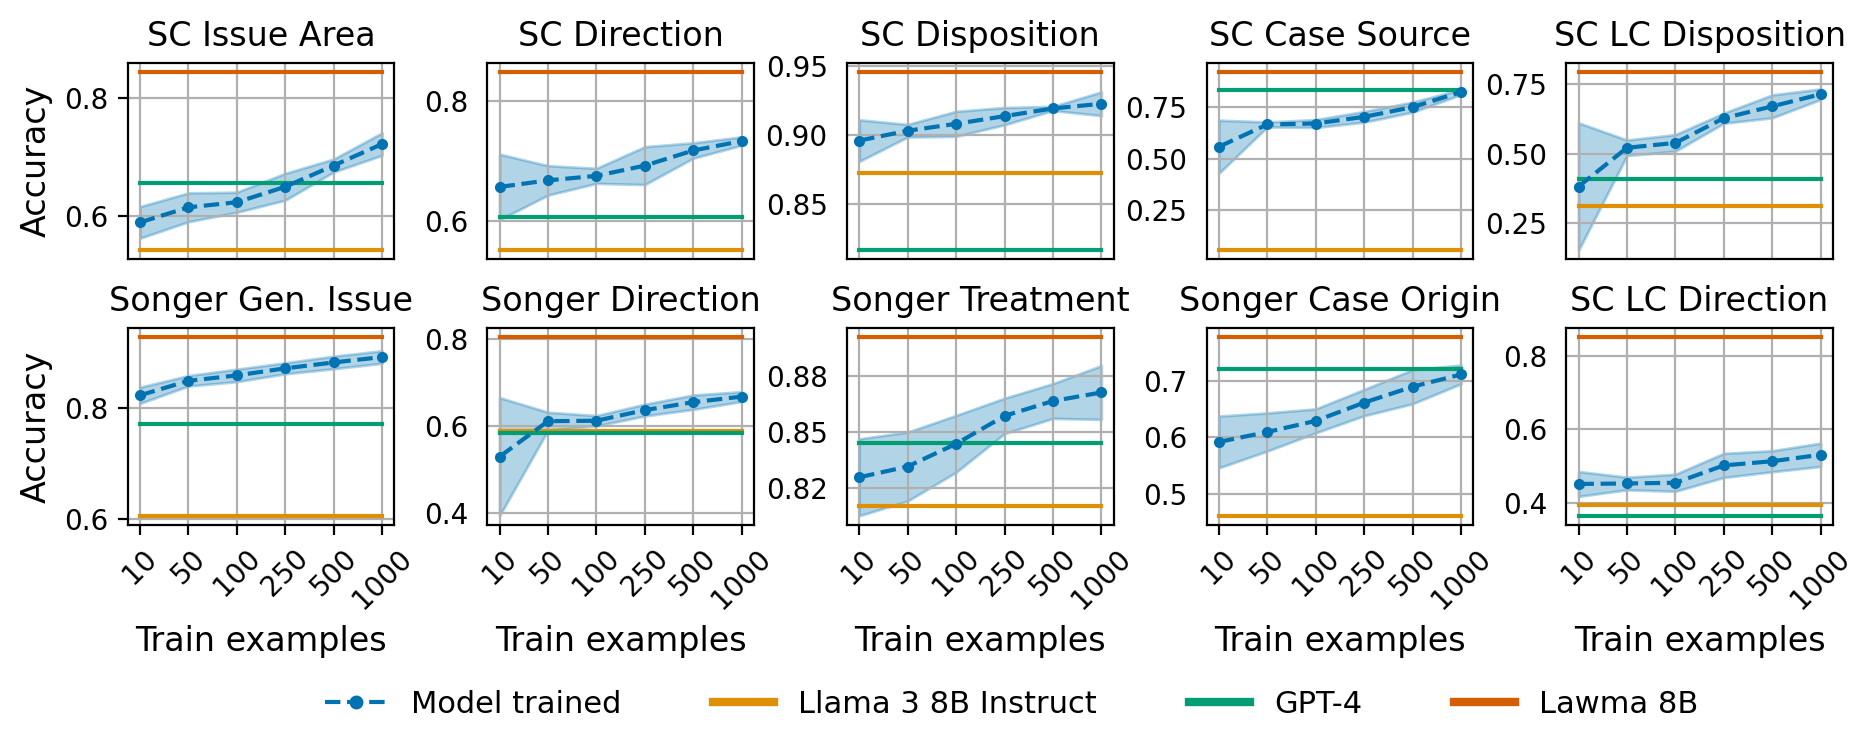

In [4]:
# one plot per task, with n as the x-axis, and accuracy as the y-axis
import matplotlib.pyplot as plt

tasks = {
        'sc_issuearea': 'SC Issue Area',
        'sc_decisiondirection': 'SC Direction',
        'sc_casedisposition': 'SC Disposition',
        'sc_casesource': 'SC Case Source',
        'sc_lcdisposition': 'SC LC Disposition',
        'songer_geniss': 'Songer Gen. Issue',
        'songer_direct1': 'Songer Direction',
        'songer_treat': 'Songer Treatment',
        'songer_origin': 'Songer Case Origin',
        'sc_lcdispositiondirection': 'SC LC Direction',
}

# 5 x 2 grid
n_tasks = len(tasks) // 2
x_axis = ['10', '50', '100', '250', '500', '1000']
map_x_axis = {k: i for i, k in enumerate(x_axis)}
x_axis_labels = ['10', '50', '100', '250', '500', '1000']

fig, axs = plt.subplots(2, n_tasks, figsize=(11, 3.), dpi=200, sharey=False, sharex=True)
for i, (task, task_name) in enumerate(tasks.items()):
    ax = axs[i // n_tasks, i % n_tasks]

    ax.set_title(task_name, fontsize=12)
    ax.grid()

    if not task in accs:
        continue

    for j, (model, model_accs) in enumerate(accs2.items()):
        if model not in models:
            continue
        if task in model_accs:
            ax.plot(range(len(x_axis)), [model_accs[task] for _ in x_axis], '-', c=model2color[model])

    task_accs = accs[task]
    keys = list(task_accs.keys())
    keys = list(set(keys) - set(['all']))
    keys = sorted(keys, key=lambda x: map_x_axis[x])

    # remove all from keys
    x = [map_x_axis[n] for n in keys]
    y = [task_accs[n]['mean'] for n in keys]
    ax.plot(x, y, '--.', c=palette[0])

    # fill between 
    yerr = [2*task_accs[n]['stddev'] for n in keys]
    ax.fill_between(x, [y[i] - yerr[i] for i in range(len(y))], 
                    [y[i] + yerr[i] for i in range(len(y))], alpha=0.3, color=palette[0])

    if i % n_tasks == 0:
        # ax.set_yticks(np.linspace(0, 1., 5))
        ax.set_ylabel('Accuracy', fontsize=12)
    else:
        ax.yaxis.set_ticks_position('none')

    if i // n_tasks == 1:
        ax.set_xlabel('Train examples', fontsize=12)
        ax.set_xticks(range(len(x_axis)), x_axis_labels, rotation=45)
    else:
        ax.xaxis.set_ticks_position('none')

    if task == 'songer_treat':
        ax.set_yticks([0.82, 0.85, 0.88])

plt.subplots_adjust(wspace=0.35, hspace=0.35)

models_ = ['llama-3-8b-instruct', 'gpt4', 'lawma-8b']
legend_elements = []
legend_elements.append(matplotlib.lines.Line2D([0], [0], linestyle='--', color=palette[0],
                                                label='Model trained', linewidth=1.5, marker='.', markersize=8))
for model in models_:
    name = models[model]
    c = model2color[model]
    legend_elements.append(matplotlib.lines.Line2D([0], [0], color=c, label=name, linewidth=3))
legend_position = (0.6, -0.7)
axs[-1, -1].legend(handles=legend_elements, loc='upper right', bbox_to_anchor=legend_position, frameon=False, fontsize=11, columnspacing=3, ncols=5)

plt.savefig('plots/eff.pdf', bbox_inches='tight')